In [ ]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Directorios de las categorías
base_dir = '/content/drive/MyDrive/Stable_difussion/images/stable_diffusion_v1_5'

categories = ['art', 'faces', 'landscapes']
languages = ['spanish', 'english']

# Función para cargar imágenes desde una carpeta
def cargar_imagenes(categoria, idioma):
    dir_categoria_idioma = os.path.join(base_dir, categoria, idioma)
    if os.path.exists(dir_categoria_idioma):
        imagenes = sorted([img for img in os.listdir(dir_categoria_idioma) if img.endswith(('.png', '.jpg', '.jpeg'))])
        return imagenes
    return []

# Cargar imágenes para cada categoría e idioma
for categoria in categories:
    for idioma in languages:
        imagenes = cargar_imagenes(categoria, idioma)
        print(f"Imágenes en la categoría '{categoria}' y idioma '{idioma}': {len(imagenes)}")
        if imagenes:
            print(f"Ejemplos de nombres de archivos: {imagenes[:5]}")

            # Mostrar algunas imágenes de ejemplo
            def mostrar_imagenes(categoria, idioma, nombres_imagenes):
                plt.figure(figsize=(15, 5))
                for i, nombre in enumerate(nombres_imagenes[:3]):
                    ruta_imagen = os.path.join(base_dir, categoria, idioma, nombre)
                    img = cv2.imread(ruta_imagen)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(1, 3, i + 1)
                    plt.imshow(img_rgb)
                    plt.title(f"{categoria} - {idioma} - {nombre}")
                    plt.axis('off')
                plt.show()

            print(f"Imágenes de ejemplo en la categoría '{categoria}' y idioma '{idioma}':")
            mostrar_imagenes(categoria, idioma, imagenes)


In [ ]:
import os
import cv2
import numpy as np

# Crear una carpeta exterior donde almacenar las imágenes normalizadas
base_dir = '/content/Normalized_Images'
os.makedirs(base_dir, exist_ok=True)

# Directorios de las categorías
categories = ['art', 'faces', 'landscapes']
languages = ['spanish', 'english']

# Función para redimensionar, convertir a escala de grises y suavizar
def preprocesar_imagen(ruta_imagen, tamaño=(256, 256)):
    img = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    img = cv2.resize(img, tamaño)  # Redimensionar a 256x256
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Escala de grises
    img_suavizada = cv2.GaussianBlur(img_gray, (5, 5), 0)  # Suavizado Gaussiano
    img_normalizada = img_suavizada.astype('float32') / 255.0  # Normalizar a [0, 1]
    return img_normalizada

# Función para guardar imágenes normalizadas
def guardar_imagen_normalizada(img_normalizada, ruta_guardado):
    # Convertir de [0,1] a [0,255] para guardar como imagen visible
    img_guardar = (img_normalizada * 255).astype(np.uint8)
    cv2.imwrite(ruta_guardado, img_guardar)

# Normalizar y guardar las imágenes de cada categoría e idioma
for category in categories:
    for language in languages:
        category_dir = f'/content/drive/MyDrive/Stable_difussion/images/stable_diffusion_v1_5/{category}/{language}'
        normalized_category_dir = os.path.join(base_dir, category, language)

        # Crear las carpetas para almacenar las imágenes normalizadas
        os.makedirs(normalized_category_dir, exist_ok=True)

        # Listar las imágenes en cada carpeta de la categoría e idioma
        images = sorted([img for img in os.listdir(category_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])

        for image_name in images:
            # Normalizar la imagen
            image_path = os.path.join(category_dir, image_name)
            img_normalized = preprocesar_imagen(image_path)

            # Guardar la imagen normalizada en la nueva carpeta
            save_path = os.path.join(normalized_category_dir, image_name)
            guardar_imagen_normalizada(img_normalized, save_path)

        print(f"Imágenes de {category} - {language} normalizadas y guardadas.")

print("\nProceso de normalización completado.")


Imágenes de art - spanish normalizadas y guardadas.
Imágenes de art - english normalizadas y guardadas.
Imágenes de faces - spanish normalizadas y guardadas.
Imágenes de faces - english normalizadas y guardadas.
Imágenes de landscapes - spanish normalizadas y guardadas.
Imágenes de landscapes - english normalizadas y guardadas.

Proceso de normalización completado.


In [ ]:
import cv2
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

# Definir las rutas de las imágenes normalizadas
base_dir = '/content/Normalized_Images'
categories = ['art', 'faces', 'landscapes']
languages = ['spanish', 'english']

# Crear una carpeta para guardar los resultados
result_base_dir = '/content/Comparison_Results'
if not os.path.exists(result_base_dir):
    os.makedirs(result_base_dir)

# Crear un archivo CSV para almacenar las estadísticas
csv_file_stats = '/content/comparison_stats.csv'
fieldnames_stats = ['Category', 'Language Pair', 'Max Distance', 'Min Distance', 'Mean Distance',
                    'Std Dev Distance', 'Max Matches', 'Min Matches', 'Mean Matches', 'Mean Keypoints']

# Abrir el archivo CSV en modo escritura
with open(csv_file_stats, mode='w', newline='') as file_stats:
    writer_stats = csv.DictWriter(file_stats, fieldnames=fieldnames_stats)
    writer_stats.writeheader()

    # Función para extraer características con SIFT
    def extract_features(image_path, descriptor_type="SIFT"):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if descriptor_type == "SIFT":
            sift = cv2.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(img, None)
        elif descriptor_type == "ORB":
            orb = cv2.ORB_create()
            keypoints, descriptors = orb.detectAndCompute(img, None)

        return keypoints, descriptors

    # Función para calcular las distancias entre dos conjuntos de descriptores
    def compute_matches(descriptors1, descriptors2, metric="euclidean"):
        if descriptors1 is None or descriptors2 is None:
            return [], []

        if metric == "euclidean":
            # Calcular distancias euclidianas (SIFT)
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            matches = bf.match(descriptors1, descriptors2)
        elif metric == "hamming":
            # Calcular distancias Hamming (ORB)
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(descriptors1, descriptors2)

        return matches

    # Función para visualizar los matches usando plot_matches
    def visualizar_matches(imagen_esp, imagen_eng, puntos_clave_esp, puntos_clave_eng, matches, metodo):
        # Convertir las imágenes a RGB para visualización
        imagen_esp_rgb = cv2.cvtColor(imagen_esp, cv2.COLOR_GRAY2RGB)
        imagen_eng_rgb = cv2.cvtColor(imagen_eng, cv2.COLOR_GRAY2RGB)

        # Crear una imagen combinada
        alto_max = max(imagen_esp_rgb.shape[0], imagen_eng_rgb.shape[0])
        ancho_total = imagen_esp_rgb.shape[1] + imagen_eng_rgb.shape[1]
        imagen_combinada = np.zeros((alto_max, ancho_total, 3), dtype=np.uint8)
        imagen_combinada[:imagen_esp_rgb.shape[0], :imagen_esp_rgb.shape[1]] = imagen_esp_rgb
        imagen_combinada[:imagen_eng_rgb.shape[0], imagen_esp_rgb.shape[1]:] = imagen_eng_rgb

        # Dibujar líneas de coincidencias
        for m in matches:
            if hasattr(m, 'queryIdx') and hasattr(m, 'trainIdx'):
                punto_esp = (int(puntos_clave_esp[m.queryIdx].pt[0]), int(puntos_clave_esp[m.queryIdx].pt[1]))
                punto_eng = (int(puntos_clave_eng[m.trainIdx].pt[0]) + imagen_esp_rgb.shape[1], int(puntos_clave_eng[m.trainIdx].pt[1]))

                # Dibujar puntos clave
                cv2.circle(imagen_combinada, punto_esp, 5, (0, 255, 0), -1)
                cv2.circle(imagen_combinada, punto_eng, 5, (0, 255, 0), -1)

                # Dibujar línea entre puntos coincidentes
                cv2.line(imagen_combinada, punto_esp, punto_eng, (255, 0, 0), 2)

        # Mostrar la imagen con matplotlib
        plt.figure(figsize=(15, 10))
        plt.imshow(imagen_combinada)
        plt.title(f'Matches usando {metodo}')
        plt.axis('off')
        plt.show()

    # Realizar comparaciones de imágenes en cada categoría y entre idiomas
    for category in categories:
        # Directorios para las imágenes en español e inglés de la misma categoría
        category_dir_1 = os.path.join(base_dir, category, 'spanish')
        category_dir_2 = os.path.join(base_dir, category, 'english')

        # Crear una carpeta para los resultados de esta comparación
        result_dir = os.path.join(result_base_dir, f"{category}_spanish_vs_english")
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)

        images_1 = sorted([img for img in os.listdir(category_dir_1) if img.endswith(('.png', '.jpg', '.jpeg'))])
        images_2 = sorted([img for img in os.listdir(category_dir_2) if img.endswith(('.png', '.jpg', '.jpeg'))])

        # Inicializar variables para las estadísticas
        total_distances = []
        total_matches = []
        total_keypoints = []

        for img1_name, img2_name in zip(images_1, images_2):
            img1_path = os.path.join(category_dir_1, img1_name)
            img2_path = os.path.join(category_dir_2, img2_name)

            # Extraer características de las imágenes
            keypoints1_sift, descriptors1_sift = extract_features(img1_path, descriptor_type="SIFT")
            keypoints2_sift, descriptors2_sift = extract_features(img2_path, descriptor_type="SIFT")

            keypoints1_orb, descriptors1_orb = extract_features(img1_path, descriptor_type="ORB")
            keypoints2_orb, descriptors2_orb = extract_features(img2_path, descriptor_type="ORB")

            # Comparar usando SIFT
            matches_sift = compute_matches(descriptors1_sift, descriptors2_sift, metric="euclidean")
            # Comparar usando ORB
            matches_orb = compute_matches(descriptors1_orb, descriptors2_orb, metric="hamming")

            # Visualizar los matches usando SIFT
            visualizar_matches(cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE),
                               cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE),
                               keypoints1_sift, keypoints2_sift, matches_sift, "SIFT")

            # Visualizar los matches usando ORB
            visualizar_matches(cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE),
                               cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE),
                               keypoints1_orb, keypoints2_orb, matches_orb, "ORB")

            # Calcular estadísticas de SIFT y ORB
            dist_sift = [m.distance for m in matches_sift if hasattr(m, 'distance')] if matches_sift else []
            dist_orb = [m.distance for m in matches_orb if hasattr(m, 'distance')] if matches_orb else []

            # Unir las distancias de SIFT y ORB
            all_distances = dist_sift + dist_orb
            total_distances.extend(all_distances)

            # Calcular coincidencias
            total_matches.append(len(matches_sift) + len(matches_orb))

            # Calcular keypoints promedio
            total_keypoints.append((len(keypoints1_sift) + len(keypoints2_sift)) / 2)

            # Guardar las imágenes comparadas
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            result_image = np.hstack((img1, img2))  # Juntar las imágenes lado a lado
            result_image_name = f"{img1_name.split('.')[0]}_vs_{img2_name.split('.')[0]}.jpg"
            result_image_path = os.path.join(result_dir, result_image_name)
            cv2.imwrite(result_image_path, result_image)

        # Calcular estadísticas generales
        distancia_max = max(total_distances) if total_distances else 0
        distancia_min = min(total_distances) if total_distances else 0
        distancia_media = np.mean(total_distances) if total_distances else 0
        desviacion_estandar = np.std(total_distances) if total_distances else 0

        coincidencias_max = max(total_matches) if total_matches else 0
        coincidencias_min = min(total_matches) if total_matches else 0
        coincidencias_prom = np.mean(total_matches) if total_matches else 0

        caracteristicas_prom = np.mean(total_keypoints) if total_keypoints else 0

        # Guardar las estadísticas en el CSV
        writer_stats.writerow({
            'Category': category,
            'Language Pair': f"spanish vs english",
            'Max Distance': distancia_max,
            'Min Distance': distancia_min,
            'Mean Distance': distancia_media,
            'Std Dev Distance': desviacion_estandar,
            'Max Matches': coincidencias_max,
            'Min Matches': coincidencias_min,
            'Mean Matches': coincidencias_prom,
            'Mean Keypoints': caracteristicas_prom
        })

print(f"Comparación completada. Los resultados están almacenados en {result_base_dir} y las estadísticas en {csv_file_stats}.")


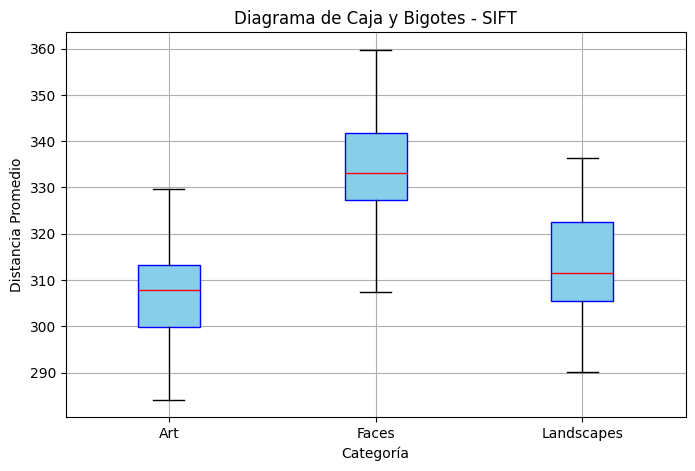

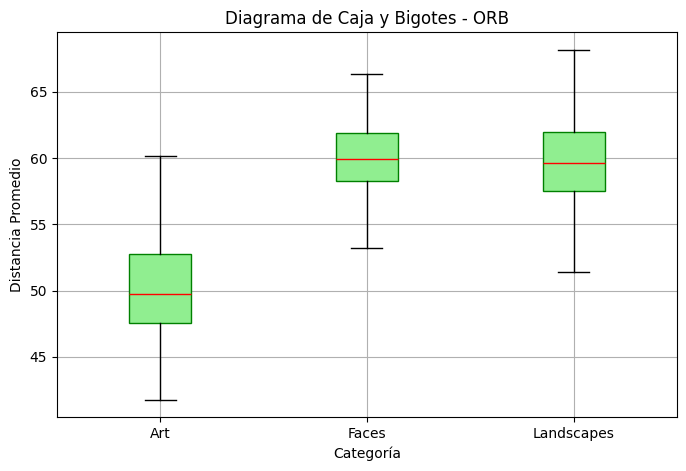

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Definir las rutas de las imágenes normalizadas
base_dir = '/content/Normalized_Images'
categories = ['art', 'faces', 'landscapes']

# Función para extraer características con SIFT y ORB
def extract_features(image_path, descriptor_type="SIFT"):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return [], None

    if descriptor_type == "SIFT":
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
    elif descriptor_type == "ORB":
        orb = cv2.ORB_create()
        keypoints, descriptors = orb.detectAndCompute(img, None)

    return keypoints, descriptors

# Función para calcular los matches
def compute_matches(descriptors1, descriptors2, metric="euclidean"):
    if descriptors1 is None or descriptors2 is None:
        return []

    if metric == "euclidean":
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    elif metric == "hamming":
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)
    return matches

# Diccionarios para almacenar datos
category_distances_sift = {}
category_distances_orb = {}

# Realizar comparaciones
for category in categories:
    category_dir_1 = os.path.join(base_dir, category, 'spanish')
    category_dir_2 = os.path.join(base_dir, category, 'english')

    images_1 = sorted([img for img in os.listdir(category_dir_1) if img.endswith(('.png', '.jpg', '.jpeg'))])
    images_2 = sorted([img for img in os.listdir(category_dir_2) if img.endswith(('.png', '.jpg', '.jpeg'))])

    sift_distances = []
    orb_distances = []

    for img1_name, img2_name in zip(images_1, images_2):
        img1_path = os.path.join(category_dir_1, img1_name)
        img2_path = os.path.join(category_dir_2, img2_name)

        # Extraer características
        _, descriptors1_sift = extract_features(img1_path, descriptor_type="SIFT")
        _, descriptors2_sift = extract_features(img2_path, descriptor_type="SIFT")

        _, descriptors1_orb = extract_features(img1_path, descriptor_type="ORB")
        _, descriptors2_orb = extract_features(img2_path, descriptor_type="ORB")

        # Comparar usando SIFT y ORB
        matches_sift = compute_matches(descriptors1_sift, descriptors2_sift, metric="euclidean")
        matches_orb = compute_matches(descriptors1_orb, descriptors2_orb, metric="hamming")

        # Guardar distancias
        if matches_sift:
            sift_distances.append(np.mean([m.distance for m in matches_sift]))
        if matches_orb:
            orb_distances.append(np.mean([m.distance for m in matches_orb]))

    # Guardar resultados por categoría
    category_distances_sift[category] = sift_distances
    category_distances_orb[category] = orb_distances

# Generar Diagramas de Caja y Bigotes SEPARADOS

# 📌 DIAGRAMA PARA SIFT
plt.figure(figsize=(8, 5))
plt.boxplot([category_distances_sift['art'], category_distances_sift['faces'], category_distances_sift['landscapes']],
            patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='blue'),
            medianprops=dict(color='red'), showfliers=False)

plt.xticks([1, 2, 3], ['Art', 'Faces', 'Landscapes'])
plt.xlabel('Categoría')
plt.ylabel('Distancia Promedio')
plt.title('Diagrama de Caja y Bigotes - SIFT')
plt.grid(True)
plt.show()

# 📌 DIAGRAMA PARA ORB
plt.figure(figsize=(8, 5))
plt.boxplot([category_distances_orb['art'], category_distances_orb['faces'], category_distances_orb['landscapes']],
            patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red'), showfliers=False)

plt.xticks([1, 2, 3], ['Art', 'Faces', 'Landscapes'])
plt.xlabel('Categoría')
plt.ylabel('Distancia Promedio')
plt.title('Diagrama de Caja y Bigotes - ORB')
plt.grid(True)
plt.show()


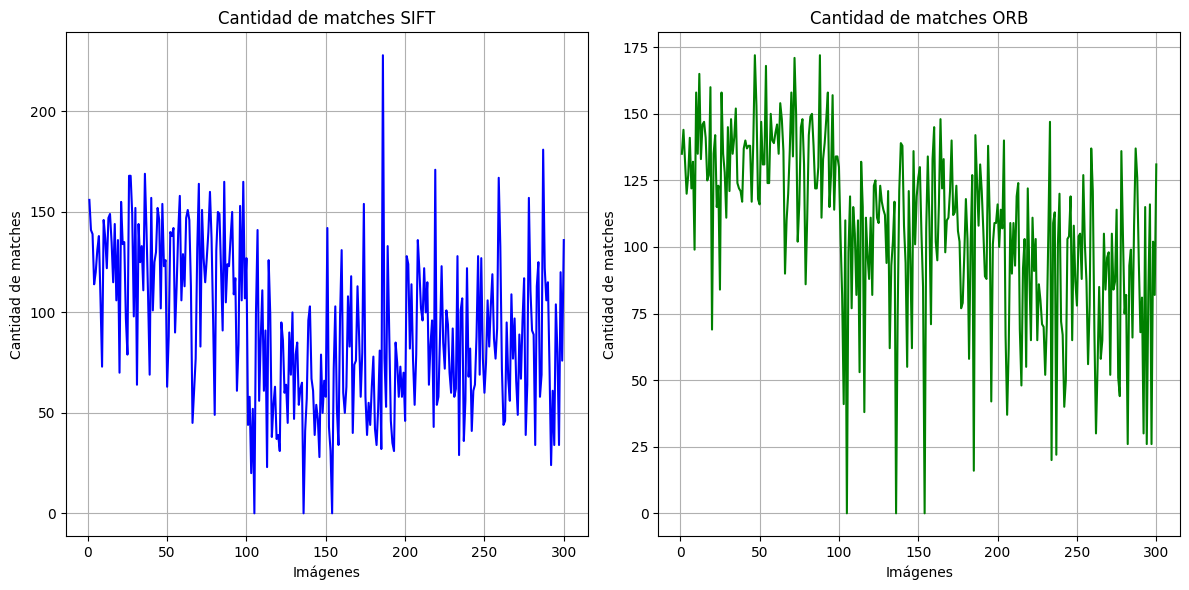

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Definir las rutas de las imágenes normalizadas
base_dir = '/content/Normalized_Images'
categories = ['art', 'faces', 'landscapes']

# Función para extraer características con SIFT y ORB
def extract_features(image_path, descriptor_type="SIFT"):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return [], None

    if descriptor_type == "SIFT":
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
    elif descriptor_type == "ORB":
        orb = cv2.ORB_create()
        keypoints, descriptors = orb.detectAndCompute(img, None)

    return keypoints, descriptors

# Función para calcular los matches
def compute_matches(descriptors1, descriptors2, metric="euclidean"):
    if descriptors1 is None or descriptors2 is None:
        return []

    if metric == "euclidean":
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    elif metric == "hamming":
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)
    return matches

# Listas para almacenar la cantidad de matches
match_counts_sift = []
match_counts_orb = []

# Realizar comparaciones
for category in categories:
    category_dir_1 = os.path.join(base_dir, category, 'spanish')
    category_dir_2 = os.path.join(base_dir, category, 'english')

    images_1 = sorted([img for img in os.listdir(category_dir_1) if img.endswith(('.png', '.jpg', '.jpeg'))])
    images_2 = sorted([img for img in os.listdir(category_dir_2) if img.endswith(('.png', '.jpg', '.jpeg'))])

    for img1_name, img2_name in zip(images_1, images_2):
        img1_path = os.path.join(category_dir_1, img1_name)
        img2_path = os.path.join(category_dir_2, img2_name)

        # Extraer características
        _, descriptors1_sift = extract_features(img1_path, descriptor_type="SIFT")
        _, descriptors2_sift = extract_features(img2_path, descriptor_type="SIFT")

        _, descriptors1_orb = extract_features(img1_path, descriptor_type="ORB")
        _, descriptors2_orb = extract_features(img2_path, descriptor_type="ORB")

        # Comparar usando SIFT y ORB
        matches_sift = compute_matches(descriptors1_sift, descriptors2_sift, metric="euclidean")
        matches_orb = compute_matches(descriptors1_orb, descriptors2_orb, metric="hamming")

        # Guardar la cantidad de matches
        match_counts_sift.append(len(matches_sift))
        match_counts_orb.append(len(matches_orb))

# Graficar cantidad de matches

plt.figure(figsize=(12, 6))

# Graficar cantidad de matches SIFT
plt.subplot(1, 2, 1)
plt.plot(range(1, len(match_counts_sift) + 1), match_counts_sift, label='Cantidad de matches', color='blue')
plt.xlabel('Imágenes')
plt.ylabel('Cantidad de matches')
plt.title('Cantidad de matches SIFT')
plt.grid(True)

# Graficar cantidad de matches ORB
plt.subplot(1, 2, 2)
plt.plot(range(1, len(match_counts_orb) + 1), match_counts_orb, label='Cantidad de matches', color='green')
plt.xlabel('Imágenes')
plt.ylabel('Cantidad de matches')
plt.title('Cantidad de matches ORB')
plt.grid(True)

plt.tight_layout()
plt.show()
